In [125]:
import os
import random
import glob
import math
import itertools
import numpy as np
import pandas as pd
import albumentations
import cv2
from webhook_1 import discord
import Potato
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


In [110]:
CLASS_NAMES = ['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']
PATH = f'D:\Dataset\potatoes\PlantVillage'

In [111]:
files = [[(file, idx) for file in glob.glob(os.path.join(PATH, cls+'\*.jpg'))] for idx, cls in enumerate(CLASS_NAMES)]
potatoes_lst = list(itertools.chain(*files))


In [112]:
df = pd.DataFrame(potatoes_lst, columns=['images', 'targets'])

In [113]:
df[CLASS_NAMES] = np.eye(max(df.targets.values)+1)[df.targets.values]

In [114]:
df = df.sample(frac=1).reset_index(drop=True)

In [115]:
df.head()

,images,targets,Potato___healthy,Potato___Late_blight,Potato___Early_blight
0,D:\Dataset\potatoes\PlantVillage\Potato___Late...,1,0.0,1.0,0.0
1,D:\Dataset\potatoes\PlantVillage\Potato___Late...,1,0.0,1.0,0.0
2,D:\Dataset\potatoes\PlantVillage\Potato___Earl...,2,0.0,0.0,1.0
3,D:\Dataset\potatoes\PlantVillage\Potato___Earl...,2,0.0,0.0,1.0
4,D:\Dataset\potatoes\PlantVillage\Potato___Earl...,2,0.0,0.0,1.0


In [116]:
def visualize_image(df, figsize=(16, 16), n_images=7):
    plt.figure(figsize=figsize)
    w = int(n_images ** .5)
    h = math.ceil(n_images / w) 
    all_names = df.images.to_list()
    image_names = random.sample(all_names, n_images)
    titles = [i.split('\\')[-2] for i in image_names]
    for ind, (image_name, title) in enumerate(tuple(zip(image_names, titles)) ):   
            img = cv2.imread(image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
            plt.subplot(w, h, ind + 1)
            plt.title(title)
            plt.imshow(img)
            plt.axis("off")          
    plt.show()
    

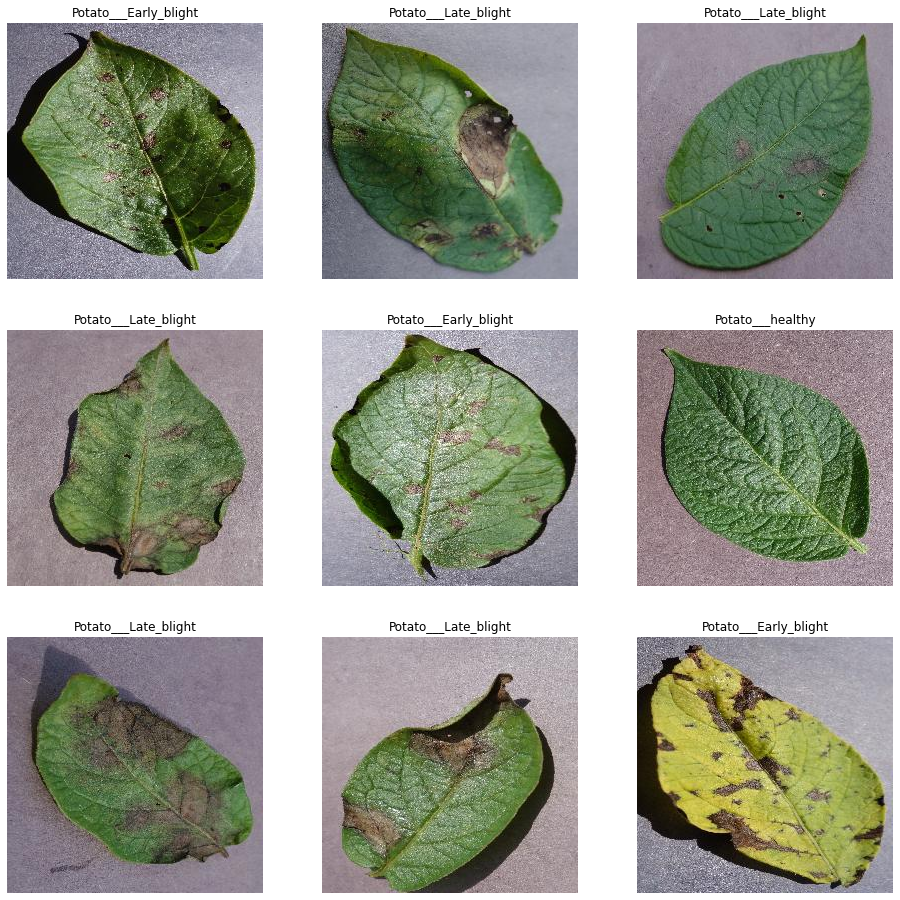

In [117]:
visualize_image(df, figsize=(16, 16), n_images=9)

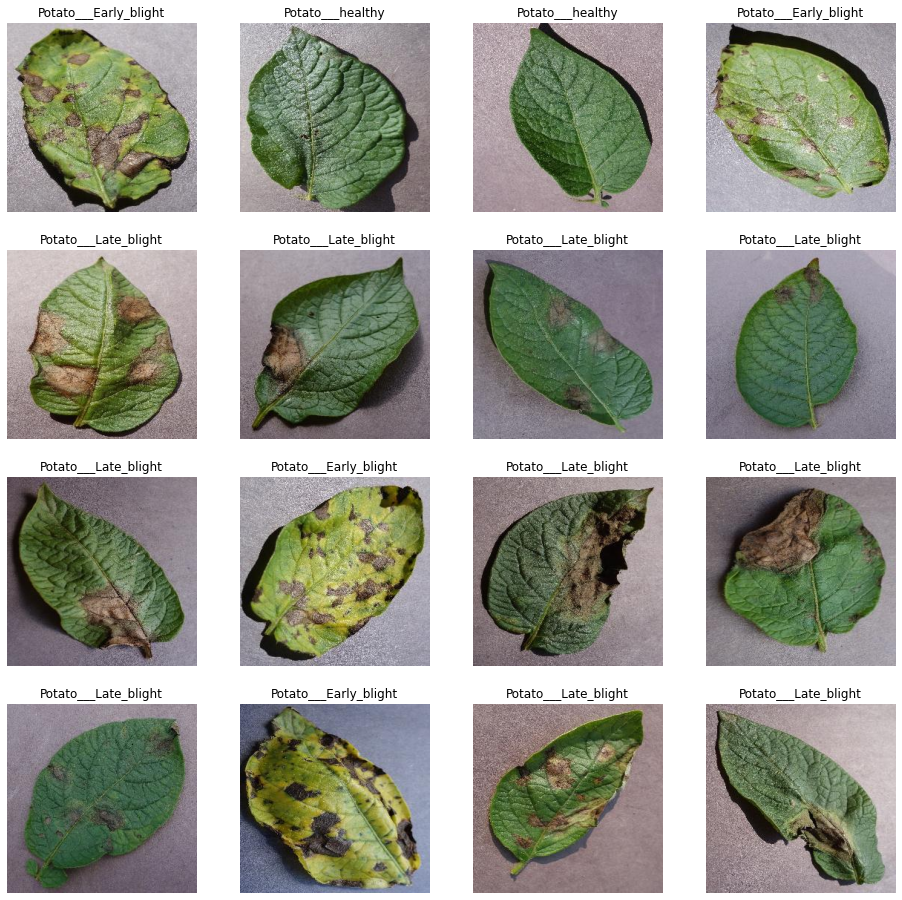

In [118]:
visualize_image(df, figsize=(16, 16), n_images=16)

In [119]:
targets = df[CLASS_NAMES].values

In [120]:
x_train, x_test, y_train, y_test = train_test_split(df['images'], targets, test_size=0.10, random_state=42)

In [121]:
class PotatoDataset(Dataset):
    def __init__(self, images, targets, resize=(256, 256), augmentations=None):
        self.images = images
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        target = self.targets[idx]
        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )           
            
        image = np.array(image)
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image)
        target = torch.tensor(target, dtype=torch.float)
        return image, target

In [122]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
p=0.5


train_aug = albumentations.Compose(
        [     
        albumentations.RandomResizedCrop(256, 256),
        albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),  
        ]
)

    
valid_aug = albumentations.Compose(
            [
                albumentations.Normalize(mean, std, max_pixel_value=255.0, always_apply=True),
            ]
)

In [126]:
train_ds = Potato.PotatoDataset(x_train.values, y_train, augmentations=train_aug)
valid_ds = Potato.PotatoDataset(x_test.values, y_test, augmentations=valid_aug)

In [139]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=16, shuffle=True, num_workers=4, pin_memory=False)

In [128]:
class PotatoModel(nn.Module):
    def __init__(self):
        super(PotatoModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.max_pool = nn.MaxPool2d((2,2))
        self.linear = nn.Linear(in_features=64*2*2, out_features=3)
    
    def forward(self, image):
        X = F.relu(self.conv1(image))
        X = self.max_pool(X)
        X = F.relu(self.conv2(X))
        X = self.max_pool(X)
        X = F.relu(self.conv3(X))
        X = self.max_pool(X)
        X = F.relu(self.conv4(X))
        X = self.max_pool(X) 
        X = F.relu(self.conv5(X))
        X = self.max_pool(X)
        X = F.relu(self.conv6(X))
        X = self.max_pool(X) 
        X = X.view(-1, 64*2*2)
        X = self.linear(X)
        return X

In [129]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size = (11, 11), stride = (4, 4), padding=0)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size = (5, 5), stride = (1, 1), padding=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size = (3, 3), stride = (1, 1), padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size = (3, 3), stride = (1, 1), padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size = (3, 3), stride = (1, 1), padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size = (3, 3), stride = (2, 2))
        self.dropout = nn.Dropout(0.5)
        self.linear1 = nn.Linear(in_features=256*6*6, out_features=4096)
        self.linear2 = nn.Linear(in_features=4096, out_features=3)
    
    def forward(self, image):
        X = F.relu(self.conv1(image))
        X = self.max_pool(X)
        X = F.relu(self.conv2(X))
        X = self.max_pool(X)
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = F.relu(self.conv5(X))
        X = self.max_pool(X)
        X = self.dropout(X)
        X = X.view(-1, 256*6*6)
        X = self.linear1(X)
        X = self.dropout(X)
        X = self.linear2(X)
        return X

In [130]:
def train_fn(model, train_dataloader, optimizer, scheduler, loss_fn=None):
    model.train()
    
    predictions = []
    targets = []
    train_loss = 0
    
    for image, label in train_dataloader:
        image, label = image.to('cuda'), label.to('cuda')
        output = model(image)
        loss = loss_fn(output, label)
        train_loss +=loss.item()
        
        predictions.append(torch.argmax(output, axis=1).squeeze().cpu().detach().numpy())
        targets.append(torch.argmax(label, axis=1).squeeze().cpu().detach().numpy())
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
    return loss/len(train_dataloader), np.concatenate(predictions), np.concatenate(targets)

In [131]:
def valid_fn(model, valid_dataloader, loss_fn=None):
    
    model.eval()
    
    predictions = []
    targets = []
    valid_loss = 0
    
    for image, label in valid_dataloader:
        image, label = image.to('cuda'), label.to('cuda')
        output = model(image)
        loss = loss_fn(output, label)
        valid_loss +=loss.item()
        predictions.append(torch.argmax(output, axis=1).squeeze().cpu().detach().numpy())
        targets.append(torch.argmax(label, axis=1).squeeze().cpu().detach().numpy())
        
    return valid_loss/len(valid_dataloader), np.concatenate(predictions), np.concatenate(targets)

In [143]:
def inference_fn(model, dataloader):
    model.eval()
    predictions = [] 
    targets = []
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to('cuda'), label.to('cuda')
            output = model(image)
            predictions.append(torch.argmax(output, axis=1).squeeze().cpu().detach().numpy())
            targets.append(torch.argmax(label, axis=1).squeeze().cpu().detach().numpy())
            
    return np.concatenate(predictions), np.concatenate(targets)

In [133]:
def run_model():    
    EPOCHS = 50
    best_loss = np.inf
    
    notify = discord()
    
    model = AlexNet()
    model.to('cuda')
    loss_fn_ = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1
    )
    
    for _ in range(EPOCHS): 
        train_loss, train_preds, train_targets = train_fn(model, train_loader, optimizer, scheduler, loss_fn=loss_fn_)
        valid_loss, valid_preds, valid_targets = valid_fn(model, valid_loader, loss_fn=loss_fn_)
        trian_score = accuracy_score(train_targets, train_preds)
        valid_score = accuracy_score(valid_targets, valid_preds)
        print(f'EPOCHS: {i}, train accuracy_score: {trian_score}')
        print(f'EPOCHS: {i}, valid accuracy_score: {valid_score}')
        
        notify(valid_score, False)
        
        if valid_loss<best_loss:
            best_loss = valid_loss
            notify(valid_score, True)
            print(f'best loss is : {best_loss}')
            torch.save(model.state_dict(), 'cnn_model.pt')

In [134]:
if __name__ == '__main__':
    run_model()

EPOCHS: 2, train accuracy_score: 0.7572314049586777
EPOCHS: 2, valid accuracy_score: 0.8055555555555556
best loss is : 0.3231747214283262
EPOCHS: 2, train accuracy_score: 0.8130165289256198
EPOCHS: 2, valid accuracy_score: 0.8101851851851852
best loss is : 0.303654174719538
EPOCHS: 2, train accuracy_score: 0.8109504132231405
EPOCHS: 2, valid accuracy_score: 0.75
EPOCHS: 2, train accuracy_score: 0.8362603305785123
EPOCHS: 2, valid accuracy_score: 0.7870370370370371
EPOCHS: 2, train accuracy_score: 0.8543388429752066
EPOCHS: 2, valid accuracy_score: 0.8148148148148148
EPOCHS: 2, train accuracy_score: 0.8801652892561983
EPOCHS: 2, valid accuracy_score: 0.7731481481481481
EPOCHS: 2, train accuracy_score: 0.8414256198347108
EPOCHS: 2, valid accuracy_score: 0.8518518518518519
best loss is : 0.2641185854694673
EPOCHS: 2, train accuracy_score: 0.8832644628099173
EPOCHS: 2, valid accuracy_score: 0.9444444444444444
best loss is : 0.13979043465639865
EPOCHS: 2, train accuracy_score: 0.90392561983

KeyboardInterrupt: 

In [136]:
model =AlexNet()
model.load_state_dict(torch.load('cnn_model.pt'))
model.to('cuda')

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=9216, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=3, bias=True)
)

In [144]:
preds, targets_ = inference_fn(model, valid_loader)

In [149]:
[CLASS_NAMES[i] for i in preds.tolist()]

['Potato___Late_blight',
 'Potato___Late_blight',
 'Potato___Late_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___Early_blight',
 'Potato___Early_blight',
 'Po

In [148]:
targets_.tolist()

[1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 0,
 2,
 1]